# Projeto 02 - Modelo previsão bitcoin ARIMA, SARIMA

![title](img/img_01.jpg)

**Objetivo do modelo e fazer previsão futuras da privisão dados**

Vou trabalhar inicialmente apenas com os dados Bitcoin e posso, no futuro, generalizar o código e usá-lo para outros cryptos se funcionar para Bitcoin.

- **Modelo 01 ARIMA**
- **Modelo 02 SARIMA**

In [1]:
from platform import python_version

print('Versão python neste Jupyter Notebook:', python_version())

Versão python neste Jupyter Notebook: 3.7.6


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib as m
import matplotlib.pyplot as plt

from scipy import stats
from pandas import DataFrame
from datetime import datetime, timedelta
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [3]:
#%reload_ext watermark

#%watermark -a "Rafael Gallo" --iversions

In [4]:
plt.rcParams["figure.figsize"] = (15,7)

plt.style.use('fivethirtyeight')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

**Base dados**

In [5]:
# Convertendo data em datetime para time series
time = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/RafaelGallo/Mentoria-machine-learning---DSA-2021/main/R/BTC-Train.csv', parse_dates=['Date'], index_col='Date', date_parser=time)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008.0
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992.0
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000.0
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984.0
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008.0


In [49]:
#Exibindo 5 primeiros colunas

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008.0
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992.0
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000.0
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984.0
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008.0


In [7]:
# Exibindo 5 últimas colunas

df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-07,52660.480469,52853.765625,43285.207031,46811.128906,46811.128906,6.521006e+10
2021-09-08,46827.761719,47334.054688,44561.394531,46091.390625,46091.390625,4.900776e+10
2021-09-09,45774.742188,47261.949219,45669.738281,46391.421875,46391.421875,3.867266e+10
2021-09-10,46396.664063,47031.742188,44344.484375,44883.910156,44883.910156,3.915467e+10
2021-09-11,44869.816406,45922.839844,44855.558594,45743.746094,45743.746094,3.702297e+10


In [8]:
# Número de linhas e colunas 

df.shape

(1715, 6)

In [9]:
# Informando as informações e das variaveis 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1715 entries, 2017-01-01 to 2021-09-11
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1711 non-null   float64
 1   High       1711 non-null   float64
 2   Low        1711 non-null   float64
 3   Close      1711 non-null   float64
 4   Adj Close  1711 non-null   float64
 5   Volume     1711 non-null   float64
dtypes: float64(6)
memory usage: 93.8 KB


In [10]:
# Exibido os tipos de dados
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [11]:
# Matriz correlação de pares de colunas, excluindo NA / valores nulos.
corr = df.corr()
corr

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999310,0.998633,0.998316,0.998316,0.722868
High,0.999310,1.000000,0.998545,0.999264,0.999264,0.726409
Low,0.998633,0.998545,1.000000,0.999115,0.999115,0.713810
Close,0.998316,0.999264,0.999115,1.000000,1.000000,0.720884
Adj Close,0.998316,0.999264,0.999115,1.000000,1.000000,0.720884
Volume,0.722868,0.726409,0.713810,0.720884,0.720884,1.000000


In [12]:
# Exibindo estatísticas descritivas visualizar alguns detalhes estatísticos básicos como percentil, média, padrão, etc. 
# De um quadro de dados ou uma série de valores numéricos.

df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1711.000000,1711.000000,1711.000000,1711.000000,1711.000000,1.711000e+03
mean,12995.829364,13367.666552,12589.589238,13020.890749,13020.890749,1.996782e+10
std,14215.112278,14651.619844,13707.812173,14233.216786,14233.216786,2.135635e+10
min,775.177979,823.307007,755.755981,777.757019,777.757019,6.085170e+07
25%,5077.713867,5282.096680,4987.065674,5093.062745,5093.062745,4.299460e+09
50%,8229.840820,8374.160156,8010.511719,8228.783203,8228.783203,1.460163e+10
75%,11405.894043,11696.753418,11153.544922,11407.112793,11407.112793,3.015689e+10
max,63523.753906,64863.097656,62208.964844,63503.457031,63503.457031,3.509679e+11


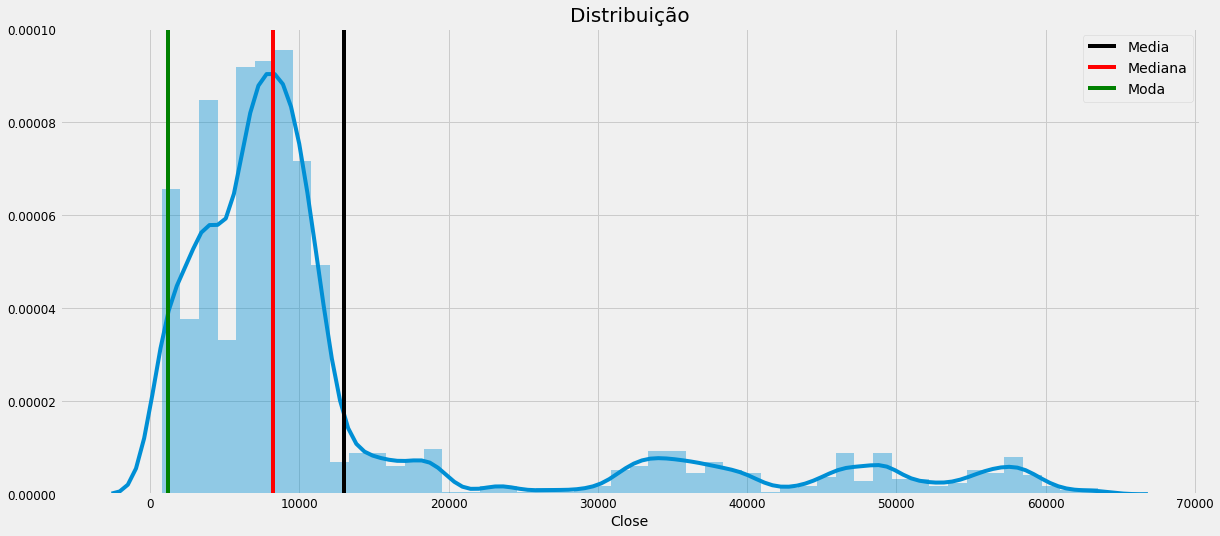

In [13]:
plt.figure(figsize=(18.2, 8))

ax = sns.distplot(df['Close']);
plt.title("Distribuição", fontsize=20)
plt.axvline(df['Close'].mean(), color='k')
plt.axvline(df['Close'].median(), color='r')
plt.axvline(df['Close'].mode()[0], color='g');
plt.legend(["Media", "Mediana", "Moda"])

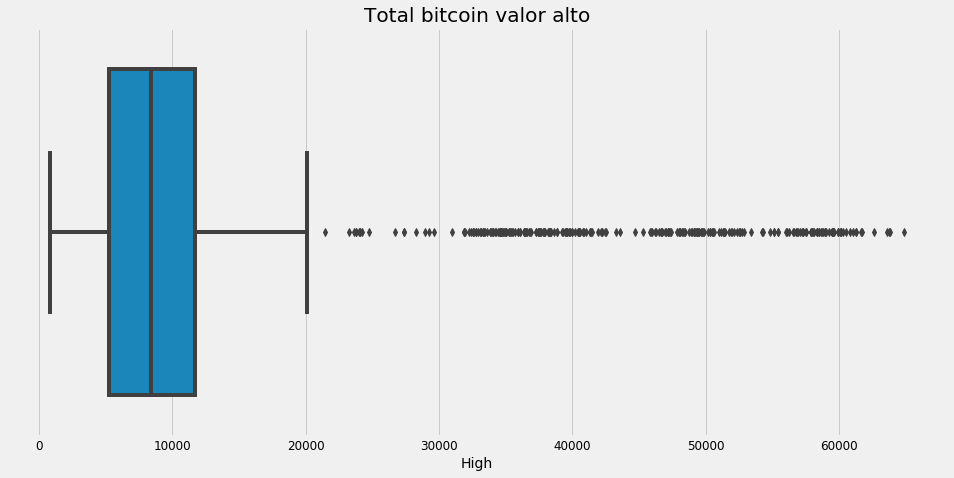

In [14]:
plt.title("Total bitcoin valor alto")
plt.xlabel("Valor")
ax = sns.boxplot(df["High"])

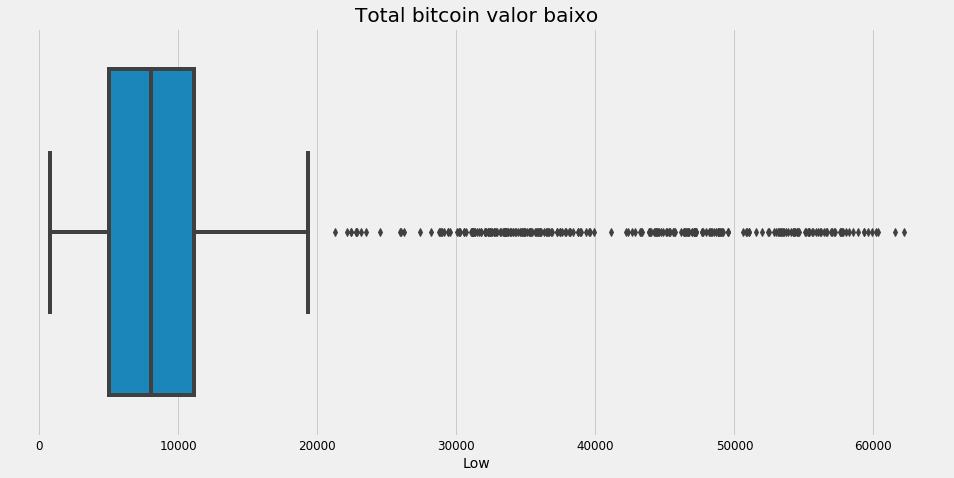

In [15]:
plt.title("Total bitcoin valor baixo")
plt.xlabel("Valor")
sns.boxplot(df["Low"])

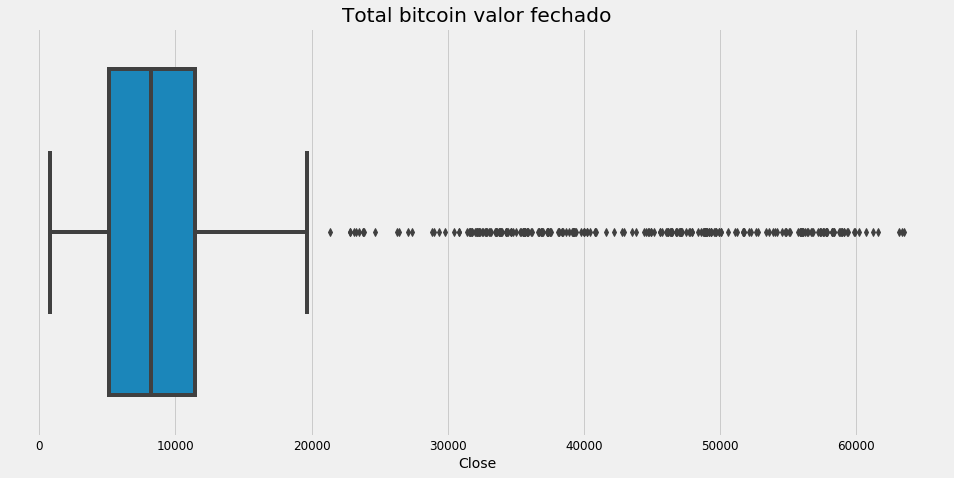

In [16]:
plt.title("Total bitcoin valor fechado")
plt.xlabel("Valor")
sns.boxplot(df["Close"])

Text(0.5, 1, 'Matriz de correlação')

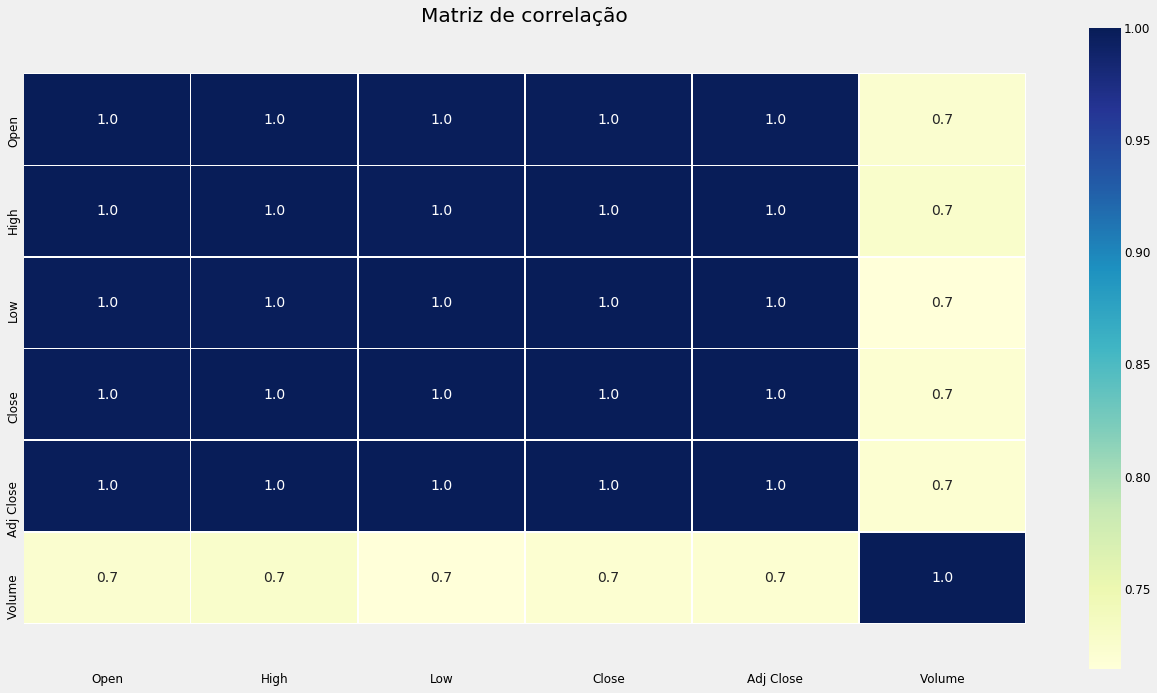

In [17]:
plt.figure(figsize=(20,11))

ax = sns.heatmap(df.corr(), annot=True, cmap='YlGnBu', linewidths=.5, annot_kws={'size':14} ,fmt=".1f")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Matriz de correlação")

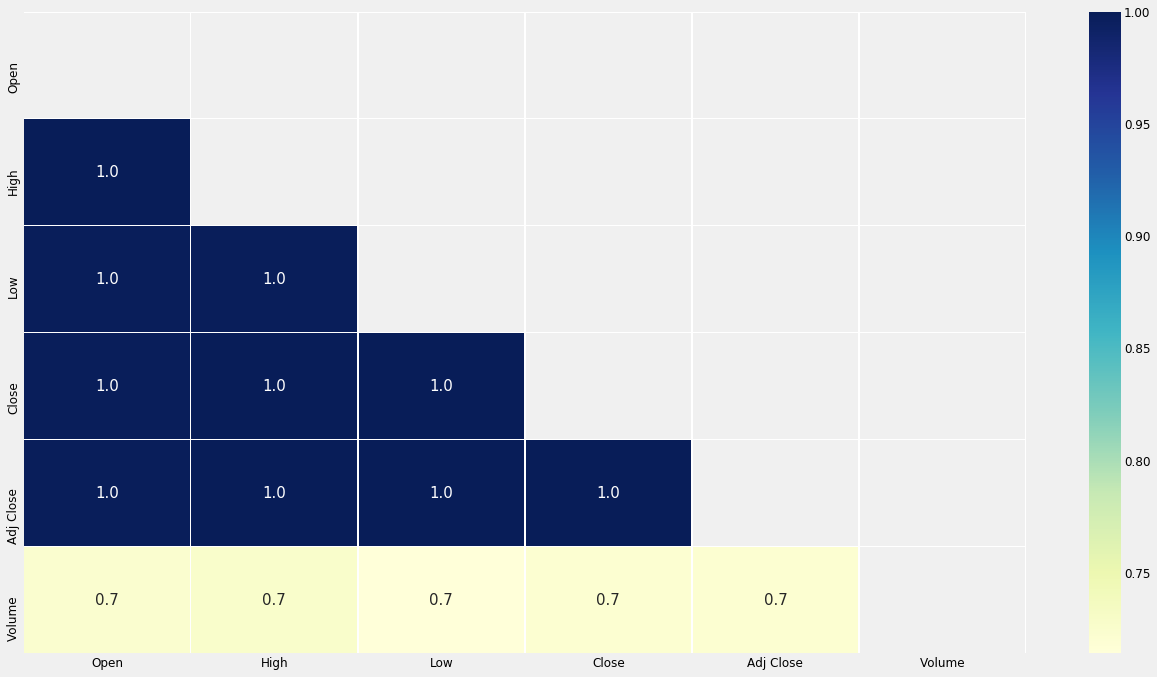

In [18]:
plt.figure(figsize=(20,11))

mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, annot = True, cmap="YlGnBu", linewidths=.5, annot_kws={'size':15} ,fmt=".1f")
plt.show()

In [19]:
# Reamostragem para frequência mensal 
df_t = df.resample('M').mean()
df_t.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-31,914.680971,937.449585,887.202387,914.916159,914.916159,1.659346e+08
2017-02-28,1055.620071,1073.503898,1040.417923,1062.533672,1062.533672,1.529558e+08
2017-03-31,1133.212576,1161.893269,1099.865671,1129.365228,1129.365228,3.507244e+08
2017-04-30,1197.646997,1216.302983,1188.384998,1206.641007,1206.641007,3.252483e+08
2017-05-31,1865.748712,1968.786782,1812.038078,1895.383529,1895.383529,1.105221e+09


# Decomposição sazonal

**Verificação de estacionariedade e decomposição sazonal**

**Se uma série temporal for estacionária, isso implica a falta de tendências gerais (mudanças na média e na variância ao longo do tempo) nos dados. Isso é importante como uma consideração na previsão de séries temporais.**

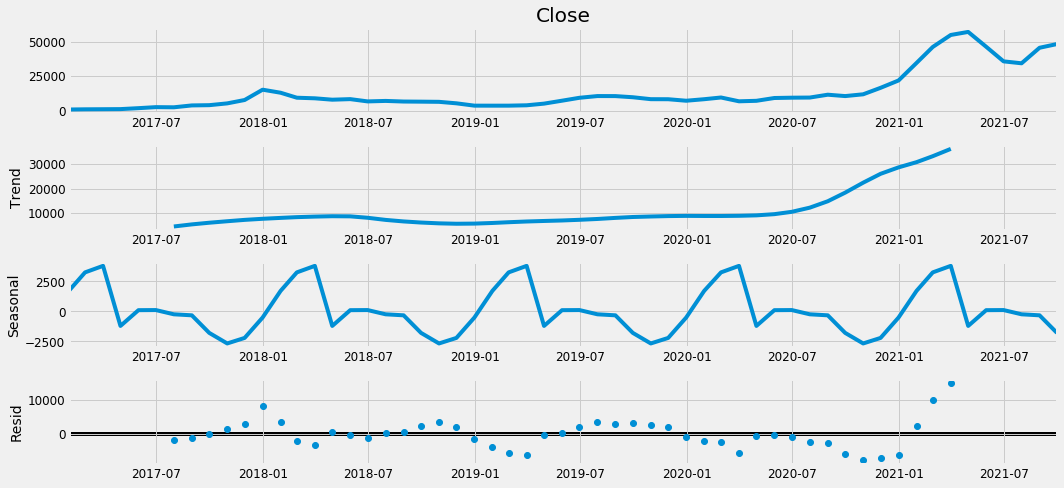

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

model_seasonal = seasonal_decompose(df_t.Close).plot()
plt.savefig('decomposição_sazonal.png')
plt.show()

# Transformação Box-Cox

**Vamos usar a transformação Box-Cox para suprimir algumas das variações**

- A transformação Box-Cox é uma família de transformações de poder indexadas por um parâmetro lambda. Sempre que você usá-lo, o parâmetro precisa ser estimado a partir dos dados. Em séries temporais, o processo pode ter uma variância não constante. se a variação muda com o tempo, o processo não é estacionário. Freqüentemente, é desejável transformar uma série temporal para torná-la estacionária. 


- Às vezes, após a aplicação de Box-Cox com um determinado valor de lambda, o processo pode parecer estacionário. Às vezes, é possível que mesmo se após a aplicação da transformação Box-Cox a série não parecer estacionária, os diagnósticos da modelagem ARIMA podem ser usados para decidir se a diferenciação ou sazonalidade pode ser útil para remover tendências polinomiais ou sazonais, respectivamente . Depois disso, o resultado pode ser um modelo ARMA que é estacionário.

# Diferenciação 

- Ao construir modelos para prever dados de série temporal (como ARIMA), outra etapa de pré-processamento é diferenciar os dados (calculando sequencialmente xt − xt − 1) até chegarmos a um ponto onde a série é estacionária. Os modelos levam em consideração as oscilações, mas não as tendências e, portanto, a consideração das tendências por diferenciação nos permite usar os modelos que levam em consideração as oscilações.

- Uma vez que o modelo foi construído, podemos contabilizar as tendências separadamente, adicionando as tendências em termos de componentes.

# Diferenciação sazonal

- Um método de diferenciação de dados é a diferenciação sazonal, que envolve o cálculo da diferença entre uma observação e a observação correspondente no ano anterior.


- O valor p indica que a série ainda não está estacionária.

- Comandos que usei para data

**Comando do pandas**
- shift(): É para deslocar os valores de índices semelhantes a data e hora em um incremento de tempo especificado um determinado número de vezes.

**Comando do Scipy**
- boxcox: Retorna um conjunto de dados transformado por uma transformação de potência Box-Cox.

**Comando do statsmodels**
- adfuller: O teste Augmented Dickey-Fuller pode ser usado para testar uma raiz unitária em um processo univariado na presença de correlação serial

In [21]:
df_t['close_box'], lmbda = stats.boxcox(df_t.Close)
df_t['box_diff_seasonal_12'] = df_t.close_box - df_t.close_box.shift(12)
df_t['box_diff_seasonal_3'] = df_t.close_box - df_t.close_box.shift(3)
df_t['box_diff2'] = df_t.box_diff_seasonal_12 - df_t.box_diff_seasonal_12.shift(1)

print()
print("Teste Dickey-Fuller: p=%f" % adfuller(df_t.close_box)[1])
print("Teste Dickey-Fuller: p=%f" % adfuller(df_t.box_diff_seasonal_12[12:])[1])
print("Teste Dickey-Fuller: p=%f" % adfuller(df_t.box_diff_seasonal_3[3:])[1])


Teste Dickey-Fuller: p=0.486574
Teste Dickey-Fuller: p=0.274849
Teste Dickey-Fuller: p=0.001580


**O valor p indica que a série é estacionária, pois o valor p calculado é inferior ao nível de significância alfa = 0,05**

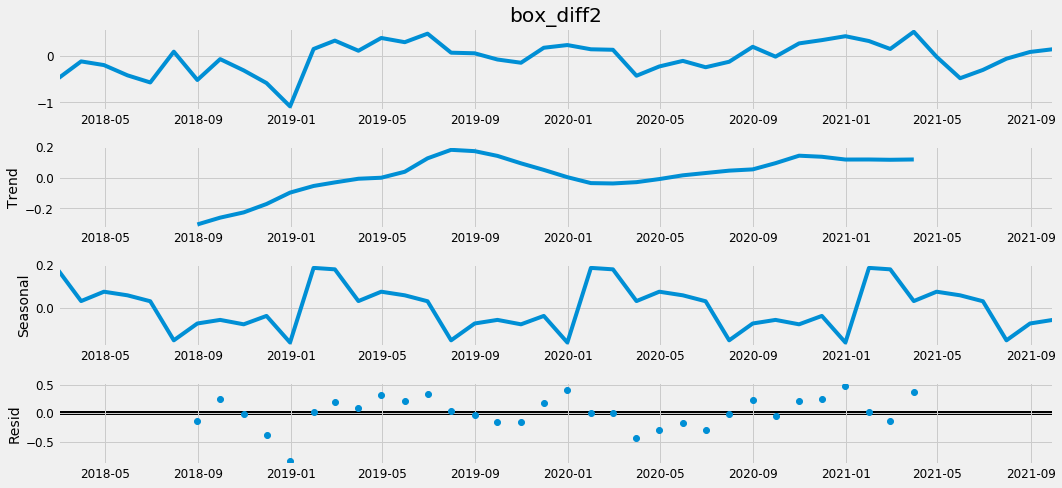

In [22]:
df_t['box_diff2'] = df_t.box_diff_seasonal_12 - df_t.box_diff_seasonal_12.shift(1)

seasonal_decompose(df_t.box_diff2[13:]).plot()
plt.savefig('decomposição_sazonal_1.png')
plt.show()

In [23]:
print("Teste Dickey-Fuller: p=%f" % adfuller(df_t.box_diff2[13:])[1])

Teste Dickey-Fuller: p=0.223376


# Autocorrelation 


- A autocorrelação é a correlação de uma série temporal com a mesma série temporal defasada. Ele resume a força de um relacionamento com uma observação em uma série de tempo com observações em etapas de tempo anteriores.


- Criamos gráficos de fator de autocorrelação (ACF) e fator de autocorrelação parcial (PACF) para identificar padrões nos dados acima que são estacionários tanto na média quanto na variância. A ideia é identificar a presença de componentes AR e MA nos resíduos.

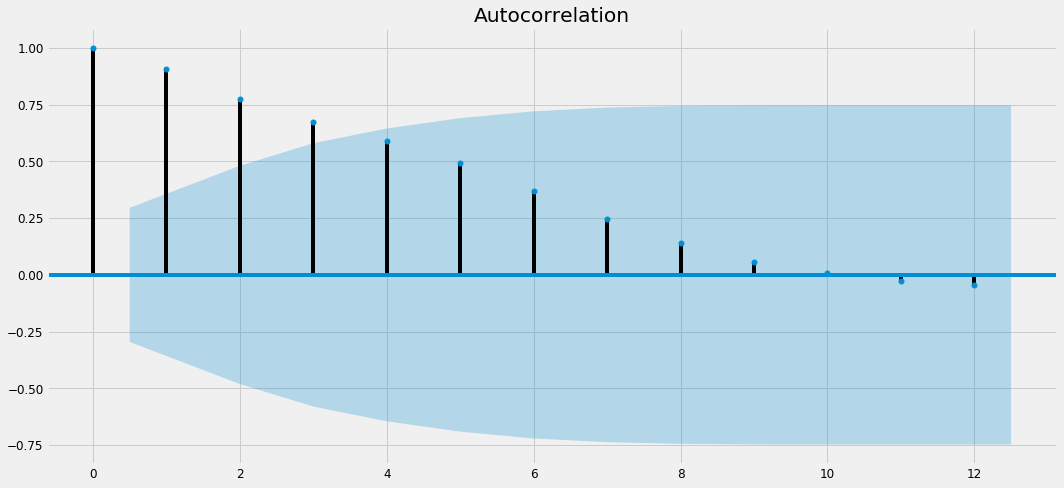

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_t.Close[13:].values.squeeze(), lags=12)

plt.tight_layout()
plt.show()

- Há uma correlação positiva com os primeiros 10 atrasos que talvez seja significativa para os primeiros 2-3 atrasos.

- Um bom ponto de partida para o parâmetro AR do modelo pode ser 3.

**Vamos experimentar a autocorrelação nas diferenças ...**


- Não há muitos picos nas parcelas fora da zona insignificante (sombreado), portanto, pode não haver informações suficientes disponíveis nos resíduos a serem extraídos pelos modelos AR e MA.


- Pode haver um componente sazonal disponível nos resíduos nas defasagens dos trimestres (3 meses) representado por picos nesses intervalos. Mas provavelmente não é significativo.

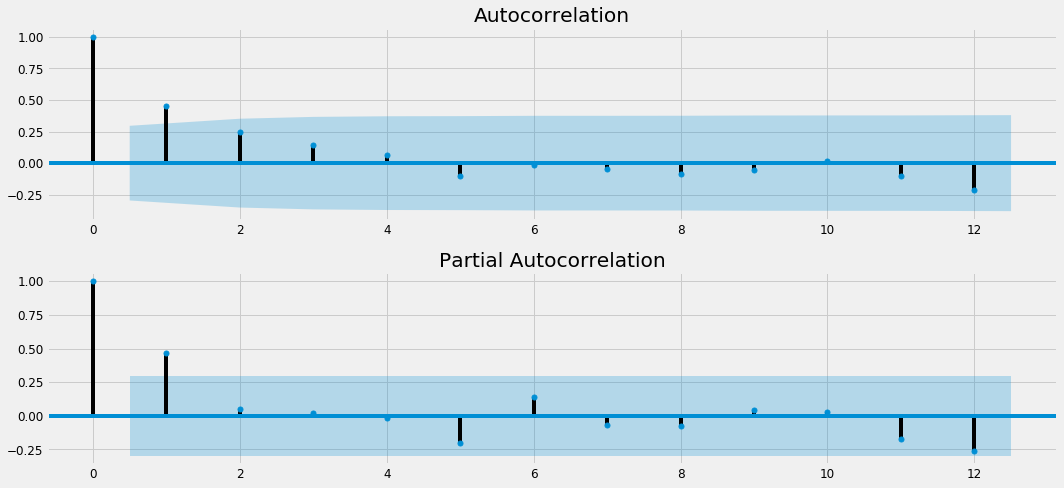

In [25]:
ax = plt.subplot(211)
plot_acf(df_t.box_diff2[13:].values.squeeze(), lags=12, ax=ax)

ax = plt.subplot(212)
plot_pacf(df_t.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

# Modelo ARIMA 

- Média Móvel AutoRegressiva Integrada



- Um modelo de regressão linear é construído incluindo o número especificado e o tipo de termos, e os dados são preparados por um grau de diferenciação para torná-los estacionários, ou seja, para remover estruturas de tendência e sazonais que afetam negativamente o modelo de regressão. Um valor de 0 para um parâmetro indica não usar aquele elemento do modelo.


- Modelos ARIMA são denotados com a notação ARIMA (p, d, q). Esses parâmetros são responsáveis pela sazonalidade, tendência e ruído em conjuntos de dados.



**p - o número de observações de defasagem a serem incluídas no modelo, ou ordem de defasagem. (AR)** 


**d - o número de vezes que as observações brutas são diferenciadas, ou o grau de diferenciação. (I)**


**q - o tamanho da janela da média móvel, também chamada de ordem da média móvel. (MA)**


- Um modelo de regressão linear é construído incluindo o número especificado e o tipo de termos, e os dados são preparados por um grau de diferenciação para torná-los estacionários, ou seja, para remover estruturas de tendência e sazonais que afetam negativamente o modelo de regressão. Um valor de 0 para um parâmetro indica não usar aquele elemento do modelo.

**Seleção de Parâmetro**


- Exploraremos iterativamente diferentes combinações de parâmetros. Para cada combinação, ajustamos um novo modelo ARIMA com SARIMAX () e avaliamos sua qualidade geral.


- Usaremos o valor AIC (Akaike Information Criterion), retornado com modelos ARIMA ajustados usando modelos de estatísticas. O AIC mede o quão bem um modelo se ajusta aos dados, levando em consideração a complexidade geral do modelo. Um modelo que se ajusta aos dados muito bem enquanto usa muitos recursos receberá uma pontuação AIC maior do que um modelo que usa menos recursos para obter a mesma qualidade de ajuste. Portanto, estamos interessados ​​em encontrar o modelo que produza o menor valor de AIC

In [36]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

qs = range(0, 3)
ps = range(0, 3)
d=1

parametros = product(ps, qs)
parametros_list = list(parametros)
len(parametros_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parametros_list:
    try:
        modelo = SARIMAX(df_t.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('Combinação de parâmetro ruim:', param)
        continue
        
    aic = modelo.aic
    if aic < best_aic:
        model_arima = modelo
        best_aic = aic
        best_param = param
    results.append([param, modelo.aic])
    
resultados = pd.DataFrame(results)
resultados.columns = ["Parametros", "AIC"]
print(resultados.sort_values(by = 'AIC', ascending=True).head())


def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

  Parametros        AIC
3     (1, 0) -10.315195
1     (0, 1)  -9.019160
7     (2, 1)  -8.492408
4     (1, 1)  -8.339508
6     (2, 0)  -8.329659


Observe que algumas combinações de parâmetros podem levar a erros de especificação numérica e desabilitamos explicitamente as mensagens de aviso para evitar uma sobrecarga de mensagens de aviso. Essas especificações incorretas também podem levar a erros e lançar uma exceção, portanto, capturamos essas exceções e apenas imprimimos as combinações de parâmetros que causam esses problemas.

**Observe que os AICs são negativos, mas isso não é um problema.**

Normalmente, AIC é positivo; no entanto, ele pode ser alterado por qualquer constante aditiva e algumas alterações podem resultar em valores negativos de AIC. [...] Não é o tamanho absoluto do valor AIC, são os valores relativos ao longo do conjunto de modelos considerados, e particularmente as diferenças entre os valores AIC, que são importantes.

Ref: Seleção de Modelo e Inferência de Multi-modelo: Uma Abordagem Prática da Teoria da Informação (Burnham e Anderson, 2004)

# Análise de Resultados 


- A coluna de coeficiente mostra o peso (ou seja, importância) de cada recurso e como cada um impacta a série temporal. O P> | z | coluna nos informa sobre a importância de cada peso de recurso. Aqui, cada peso tem um valor p inferior ou próximo a 0,05, portanto, é razoável reter todos eles em nosso modelo.


- Ao ajustar modelos ARIMA sazonais (e quaisquer outros modelos para esse assunto), é importante executar o diagnóstico do modelo para garantir que nenhuma das suposições feitas pelo modelo foi violada. O objeto plot_diagnostics nos permite gerar diagnósticos de modelo rapidamente e investigar qualquer comportamento incomum.

In [37]:
print("Teste Dickey-Fuller:: p=%f" % adfuller(model_arima.resid[13:])[1])
print()
print(model_arima.summary())

Teste Dickey-Fuller:: p=0.001032

                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   57
Model:               SARIMAX(1, 1, 0)   Log Likelihood                   7.158
Date:                Mon, 13 Sep 2021   AIC                            -10.315
Time:                        21:53:25   BIC                             -6.264
Sample:                    01-31-2017   HQIC                            -8.745
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4245      0.098      4.348      0.000       0.233       0.616
sigma2         0.0452      0.009      5.065      0.000       0.028       0.063
Ljung-Box (Q):    

# Predição

**No histograma (canto superior direito), a linha do KDE deve seguir a linha N (0,1) (distribuição normal com média 0, desvio padrão 1) de perto. Isso é uma indicação se os resíduos são normalmente distribuídos ou não**

**No Q-Q-plot, a distribuição ordenada de resíduos (pontos azuis) deve seguir a tendência linear das amostras retiradas de uma distribuição normal padrão com N (0, 1). Novamente, isso é uma indicação se os resíduos são normalmente distribuídos.**

**O gráfico residual padronizado não exibe nenhuma sazonalidade óbvia.
Isso é confirmado pelo gráfico de autocorrelação, que mostra que os resíduos da série temporal têm baixa correlação com as versões defasadas de si mesmos.**

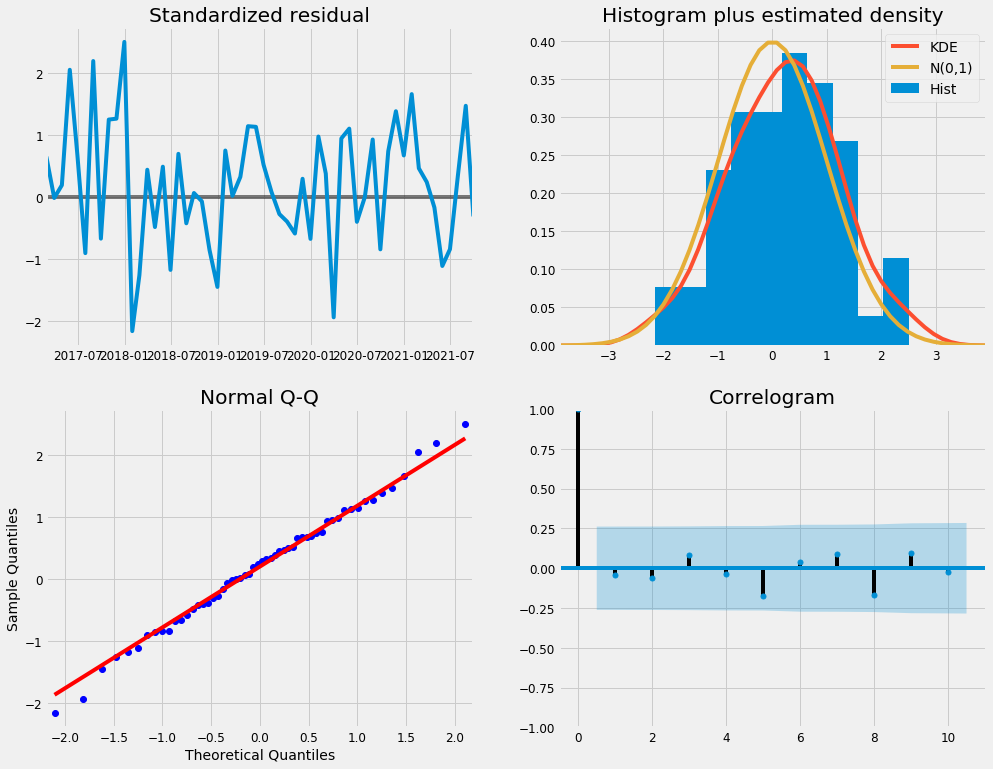

In [38]:
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

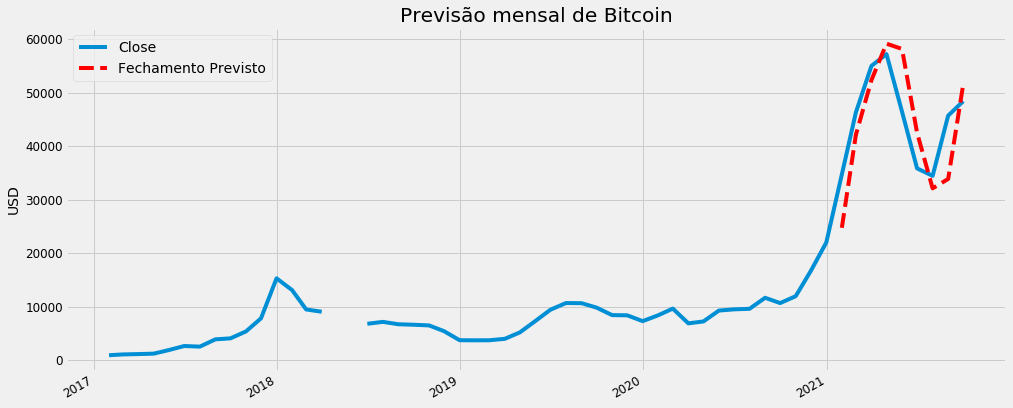

In [39]:
df_t_pred = df_t[['Close']]

date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]
future = pd.DataFrame(index=date_list, columns= df_t.columns)
df_t_pred = pd.concat([df_t_pred, future])
df_t_pred['forecast'] = invboxcox(model_arima.predict(start=datetime(2021, 1, 31), end=datetime(2021, 9, 30)), lmbda)


plt.figure(figsize=(15,7))
df_t_pred.Close.plot()
df_t_pred.forecast.plot(color='r', ls='--', label='Fechamento Previsto')
plt.legend()
plt.title('Previsão mensal de Bitcoin')
plt.ylabel('USD')
plt.savefig('Previsão_mensal_Bitcoin_ARIMA.png')
plt.show()

# Modelo SARIMAX

Média móvel integrada AutoRegressiva sazonal com modelo de regressores.

Eu não esperava que os dados de bitcoin exibissem qualquer sazonalidade, mas aparentemente eles exibem uma leve sazonalidade. Então, vamos tentar melhorar o modelo usando o SARIMA.

Quando lidamos com efeitos sazonais, usamos o ARIMA sazonal, que é denotado como ARIMA (p, d, q) (P, D, Q) s. Aqui, (p, d, q) são os parâmetros não sazonais descritos acima, enquanto (P, D, Q) seguem a mesma definição, mas são aplicados ao componente sazonal da série temporal. O termo s é a periodicidade da série temporal (4 para períodos trimestrais, 12 para períodos anuais, etc.).

Eu experimentei este modelo com períodos anuais e trimestrais (alterne as linhas comentadas para ver a sazonalidade de 12 meses).

**Seleção de Parâmetro**

O mesmo processo de seleção de parâmetros para ARIMA sazonal. Para cada combinação, ajustamos um novo modelo ARIMA sazonal com SARIMAX () e avaliamos sua qualidade geral.


In [40]:
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)

D=1
d=1

parametros = product(ps, qs, Ps, Qs)
parametros_list = list(parametros)
len(parametros_list)

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parametros_list:
    try:
        model_sarimax = SARIMAX(df_t.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    
    aic = model_sarimax.aic
    if aic < best_aic:
        best_model = model_sarimax
        best_aic = aic
        best_param = param
    
    results.append([param, model_sarimax.aic])

# Análise de Resultados

In [41]:
result_table = pd.DataFrame(results)
result_table.columns = ['Parametros', 'AIC']

print(result_table.sort_values(by = 'AIC', ascending=True).head())
print()
print("Teste Dickey-Fuller:: p=%f" % adfuller(best_model.resid[13:])[1])
print()
print(model_sarimax.summary())

      Parametros       AIC
19  (1, 0, 0, 1)  3.083779
7   (0, 1, 0, 1)  3.788190
21  (1, 0, 1, 1)  5.078105
25  (1, 1, 0, 1)  5.084458
37  (2, 0, 0, 1)  5.085339

Teste Dickey-Fuller:: p=0.005517

                                      SARIMAX Results                                      
Dep. Variable:                           close_box   No. Observations:                   57
Model:             SARIMAX(2, 1, 2)x(2, 1, [1], 4)   Log Likelihood                   2.596
Date:                             Mon, 13 Sep 2021   AIC                             10.807
Time:                                     21:53:38   BIC                             26.417
Sample:                                 01-31-2017   HQIC                            16.792
                                      - 09-30-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025 

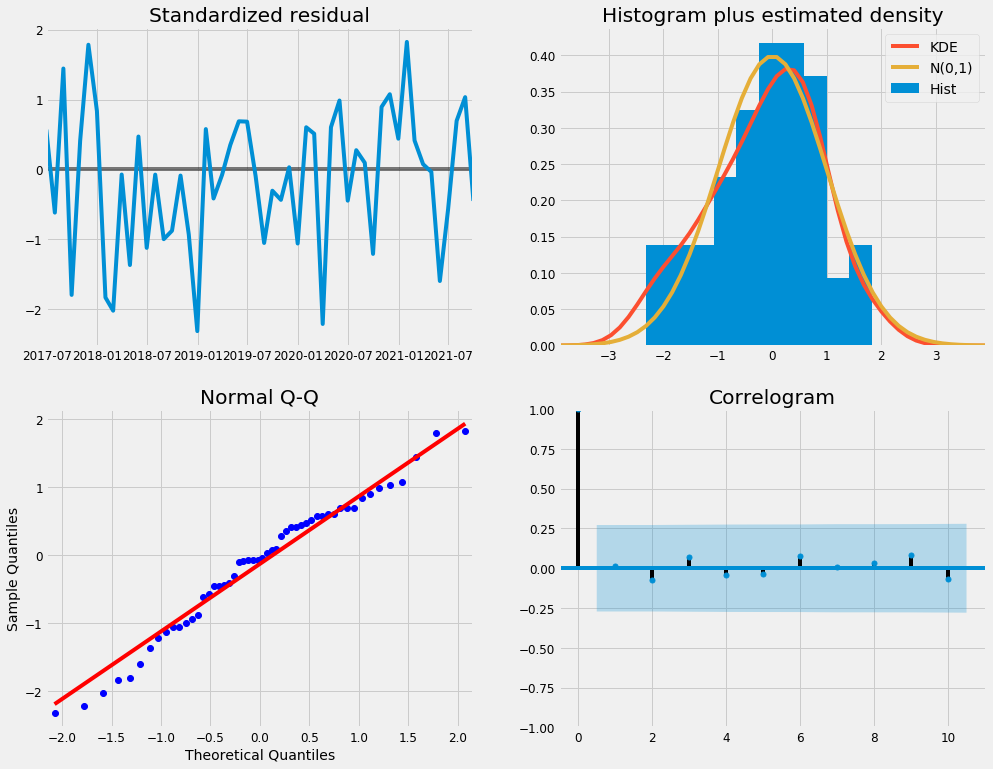

In [42]:
model_sarimax.plot_diagnostics(figsize=(15, 12))
plt.show()

Dickey–Fuller test:: p=0.095504


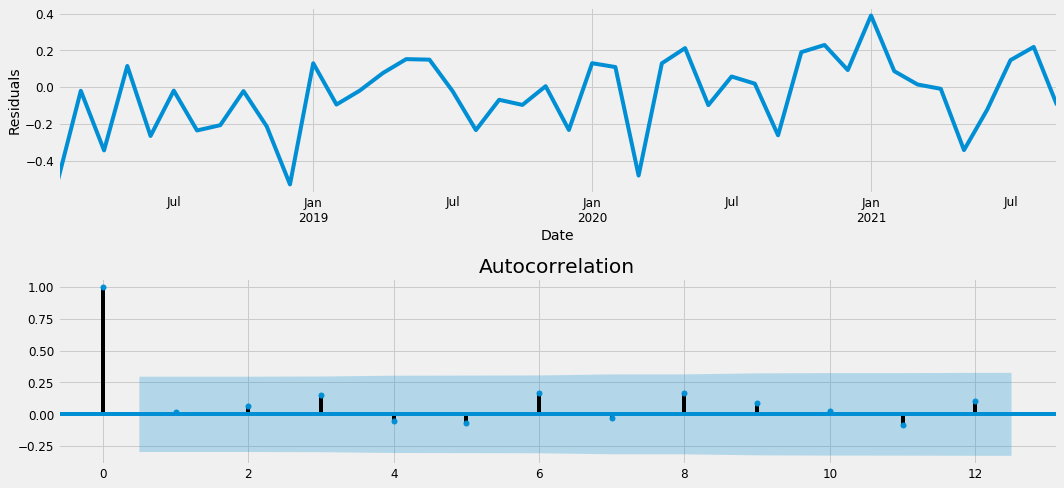

In [43]:
plt.figure(figsize=(15,7))
plt.subplot(211)
model_sarimax.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
plot_acf(model_sarimax.resid[13:].values.squeeze(), lags=12, ax=ax)
print("Dickey–Fuller test:: p=%f" % adfuller(model_sarimax.resid[13:])[1])

plt.tight_layout()
plt.show()

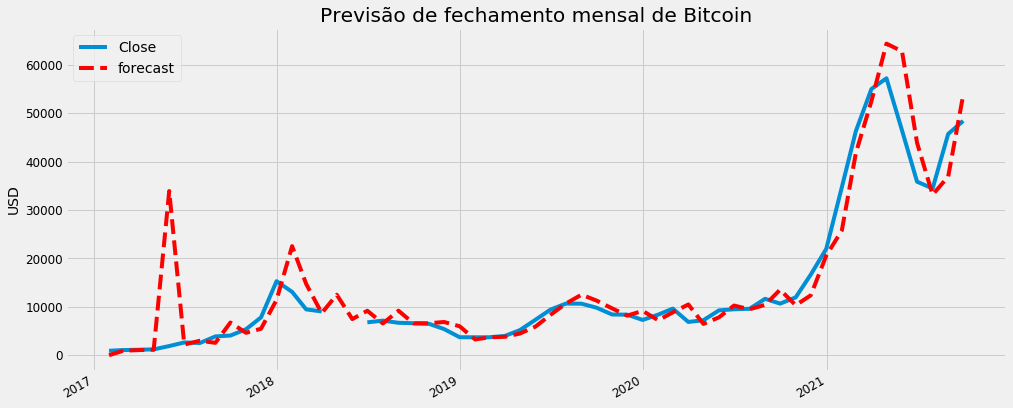

In [44]:
btc_month2 = df_t[['Close']]
date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]
future = pd.DataFrame(index=date_list, columns= df_t.columns)
btc_month2 = pd.concat([btc_month2, future])

btc_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)

plt.figure(figsize=(15,7))
btc_month2.Close.plot()
btc_month2.forecast.plot(color='r', ls='--', label='forecast')
plt.legend()
plt.title('Previsão de fechamento mensal de Bitcoin')
plt.ylabel('USD')
plt.savefig('bitcoin_mensal_previsão.png')
plt.show()

# Objetivo

**Próximo passo fazer o deploy modelo por em produção online prevendo dos os dias a moeda**

# Conclusão do projeto

**Os resultados indicam que o modelo ainda é um pouco grosseiro e não algo que devemos usar como conselho de negociação, mas isso não foi inesperado devido à natureza extremamente volátil das criptomoedas, especialmente nos últimos 6 meses**


**Provavelmente também não é uma boa ideia tentar prever 6 meses no futuro, pois podemos ver o quão insano até mesmo o intervalo de confiança de 80% se torna tão longe. Talvez seguir as previsões de 1 mês de antecedência seja mais sensato. Ou talvez até mesmo fazendo previsões no dia a dia**


**Existem várias coisas que podemos fazer para melhorar potencialmente o modelo**


- Use uma técnica diferente para padronizar a distribuição
- Use diferentes técnicas de diferenciação
- Descartar o período de tempo antes das criptomoedas começarem a decolar
- Experimente modelar por dia em vez de mês, com uma janela de previsão menor
- Use outros modelos ou aprendizado de máquina em vez de ARIMA